In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


In [2]:
# Load the dataset
data = pd.read_csv('matchups-2012.csv')
data.drop(['game', 'season'], axis=1, inplace=True)


In [3]:
dup_rows = data[data.duplicated()]
print("No. of duplicate rows: ", dup_rows.shape[0])

No. of duplicate rows:  0


In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 home_team        0
away_team        0
starting_min     0
end_min          0
home_0           0
home_1           0
home_2           0
home_3           0
home_4           0
away_0           0
away_1           0
away_2           0
away_3           0
away_4           0
fga_home         0
fta_home         0
fgm_home         0
fga_2_home       0
fgm_2_home       0
fga_3_home       0
fgm_3_home       0
ast_home         0
blk_home         0
pf_home          0
reb_home         0
dreb_home        0
oreb_home        0
to_home          0
pts_home         0
pct_home         0
pct_2_home       0
pct_3_home       0
fga_visitor      0
fta_visitor      0
fgm_visitor      0
fga_2_visitor    0
fgm_2_visitor    0
fga_3_visitor    0
fgm_3_visitor    0
ast_visitor      0
blk_visitor      0
pf_visitor       0
reb_visitor      0
dreb_visitor     0
oreb_visitor     0
to_visitor       0
pts_visitor      0
pct_visitor      0
pct_2_visitor    0
pct_3_visitor    0
outcome          0
dtype: int64


In [5]:
class PlayerLabelEncoder:
    def __init__(self):
        self.label_mapping = {}
        self.reverse_mapping = {}
        self.last_encoded_value = 999  # Start encoding from 1000

    def fit(self, data):
        unique_labels = set(data.unique())
        for label in unique_labels:
            if label not in self.label_mapping:
                self.last_encoded_value += 1
                encoded_label = self.last_encoded_value
                self.label_mapping[label] = encoded_label
                self.reverse_mapping[encoded_label] = label
        return self

    def transform(self, data):
        return data.map(self.label_mapping).fillna(self.last_encoded_value + 1)  # Fill unseen values with new encoding

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

    def get_label_mapping(self):
        return self.label_mapping
    
    def get_reverse_mapping(self):
        return self.reverse_mapping
    
    def decode_label(self, encoded_value):
        return self.reverse_mapping.get(encoded_value, None)


In [6]:
player_name_columns = ['home_team', 'away_team',
                       'home_0', 'home_1', 'home_2', 'home_3', 'home_4', 
                       'away_0', 'away_1', 'away_2', 'away_3', 'away_4']

# Initialize the encoder
player_encoder = PlayerLabelEncoder()

# Fit and transform each player name column
for col in player_name_columns:
    data[col] = player_encoder.fit_transform(data[col])
data

,home_team,away_team,starting_min,end_min,home_0,home_1,home_2,home_3,home_4,away_0,...,pf_visitor,reb_visitor,dreb_visitor,oreb_visitor,to_visitor,pts_visitor,pct_visitor,pct_2_visitor,pct_3_visitor,outcome
0,1001,1018,0,5,1075,1269,1216,1148,1391,1267,...,0,8,6,2,2,9,0.363636,0.375000,0.333333,1
1,1001,1018,6,6,1269,1075,1216,1249,1433,1267,...,0,1,1,0,0,5,1.000000,1.000000,1.000000,-1
2,1001,1018,7,8,1269,1075,1216,1249,1433,1151,...,0,4,3,1,1,4,0.500000,0.666667,0.000000,-1
3,1001,1018,9,10,1075,1269,1249,1302,1433,1230,...,0,2,2,0,0,4,0.500000,0.666667,0.000000,-1
4,1001,1018,11,11,1269,1195,1249,1302,1433,1230,...,0,1,1,0,0,6,1.000000,0.000000,1.000000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21236,1010,1026,38,39,1226,1330,1368,1401,1489,1185,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,-1
21237,1010,1026,40,41,1226,1330,1368,1401,1489,1185,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,-1
21238,1010,1026,42,42,1226,1194,1183,1330,1401,1185,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,-1
21239,1010,1026,43,45,1226,1183,1330,1401,1489,1185,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,-1


/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8 23 41] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


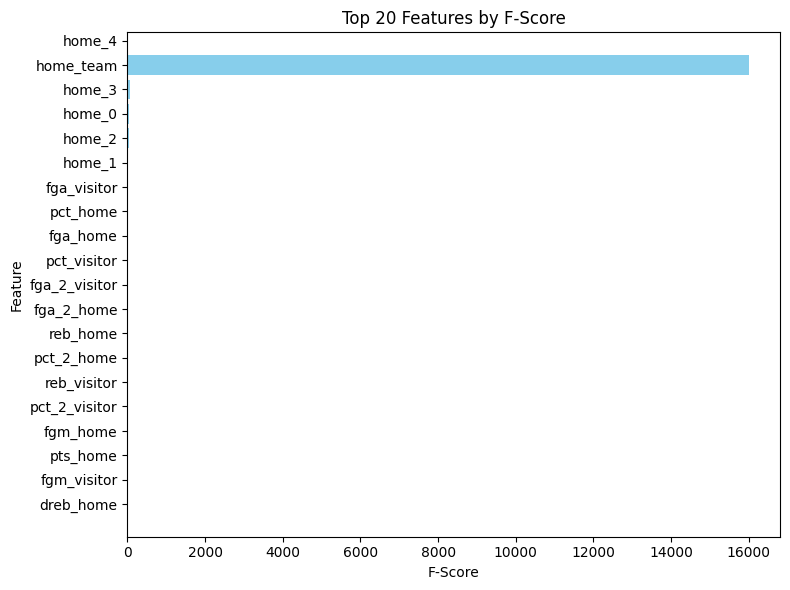

In [29]:
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

# Perform ANOVA analysis
f_scores, p_values = f_classif(data, data['home_4'])

# Create a DataFrame to store feature importance scores
feature_importance = pd.DataFrame({'Feature': data.columns, 'F_Score': f_scores, 'P_Value': p_values})

# Sort features by F-score in descending order
feature_importance.sort_values(by='F_Score', ascending=False, inplace=True)

N = 20  # Number of top features to display
top_features = feature_importance.nlargest(N, 'F_Score')

plt.figure(figsize=(8, 6))
plt.barh(top_features['Feature'], top_features['F_Score'], color='skyblue')
plt.xlabel('F-Score')
plt.ylabel('Feature')
plt.title(f'Top {N} Features by F-Score')
plt.gca().invert_yaxis()  # Invert y-axis to display highest score at the top
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

In [92]:
#Skip
# Get the value counts of home_4
home_4_value_counts = data['home_4'].value_counts()

# Divide into 3 lists based on frequency
popular_players = home_4_value_counts[home_4_value_counts > 50].index.tolist()
semi_popular_players = home_4_value_counts[(home_4_value_counts >= 10) & (home_4_value_counts <= 50)].index.tolist()
rare_players = home_4_value_counts[home_4_value_counts < 10].index.tolist()

# Iterate through rare_players
for rare_player in rare_players:
    # Iterate through the dataset
    for index, row in data.iterrows():
        # Check if the rare_player is in home_4 column
        if rare_player == row['home_4']:
            # Check if any popular player is in other home columns
            for player_column in ['home_0', 'home_1', 'home_2', 'home_3']:
                if row[player_column] in popular_players:
                    # Exchange rare player with popular player in home_4
                    data.at[index, 'home_4'] = row[player_column]
                    break  # Break out of the inner loop once exchange is done


In [7]:
selected_features = ['home_team', 'away_team',
                       'home_0', 'home_1', 'home_2', 'home_3', 
                       'away_0', 'away_1', 'away_2', 'away_3', 'away_4', 'outcome', 'home_4']
# Copy selected features to another dataset
data_selected = data[selected_features].copy()
data_selected

,home_team,away_team,home_0,home_1,home_2,home_3,away_0,away_1,away_2,away_3,away_4,outcome,home_4
0,1001,1018,1075,1269,1216,1148,1267,1180,1336,1386,1439,1,1391
1,1001,1018,1269,1075,1216,1249,1267,1180,1336,1386,1439,-1,1433
2,1001,1018,1269,1075,1216,1249,1151,1180,1336,1386,1439,-1,1433
3,1001,1018,1075,1269,1249,1302,1230,1151,1180,1336,1439,-1,1433
4,1001,1018,1269,1195,1249,1302,1230,1151,1270,1180,1380,-1,1433
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21236,1010,1026,1226,1330,1368,1401,1185,1051,1060,1327,1383,-1,1489
21237,1010,1026,1226,1330,1368,1401,1185,1060,1044,1327,1383,-1,1489
21238,1010,1026,1226,1194,1183,1330,1185,1060,1044,1327,1383,-1,1401
21239,1010,1026,1226,1183,1330,1401,1185,1060,1044,1327,1383,-1,1489


In [8]:
data_selected['home_4'].value_counts()

home_4
1484    512
1480    463
1478    453
1439    436
1486    430
       ... 
1369      1
1213      1
1344      1
1059      1
1322      1
Name: count, Length: 236, dtype: int64

In [33]:
# Split the data into features (X) and target variable (y)
y = data_selected['home_4']
X = data_selected.drop(columns=['home_4'])

# # Apply SMOTE to balance the dataset
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)


In [9]:
# Split the data into features (X) and target variable (y)
y = data_selected['home_4']
X = data_selected.drop(columns=['home_4'])

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Split the resampled data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
#Baseline Random Forest Classifier 

# Train a random forest classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the performance of random forest classifier model
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
#f1_rf = f1_score(y_test, y_pred_rf)
#recall_rf = recall_score(y_test, y_pred_rf)

print("\nRandom Forest Classifier Model:")
print("Accuracy:", accuracy_rf)
#print("F1 Score:", f1_rf)
#print("Recall Score:", recall_rf)

# Generate and print the classification report
report = classification_report(y_test, y_pred_rf)
print("Classification Report:")
print(report)


Random Forest Classifier Model:
Accuracy: 0.7825370675453048
Classification Report:
              precision    recall  f1-score   support

        1034       0.00      0.00      0.00         1
        1036       0.81      1.00      0.90        13
        1044       0.25      1.00      0.40         1
        1053       0.00      0.00      0.00         3
        1055       0.00      0.00      0.00         0
        1063       0.00      0.00      0.00         0
        1066       0.75      1.00      0.86         3
        1069       0.77      0.63      0.69        27
        1076       0.00      0.00      0.00         0
        1089       0.00      0.00      0.00         1
        1116       1.00      0.50      0.67         2
        1128       0.88      0.64      0.74        11
        1133       0.75      1.00      0.86         9
        1137       0.25      0.50      0.33         2
        1163       0.00      0.00      0.00         1
        1166       0.69      0.80      0.74       

/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

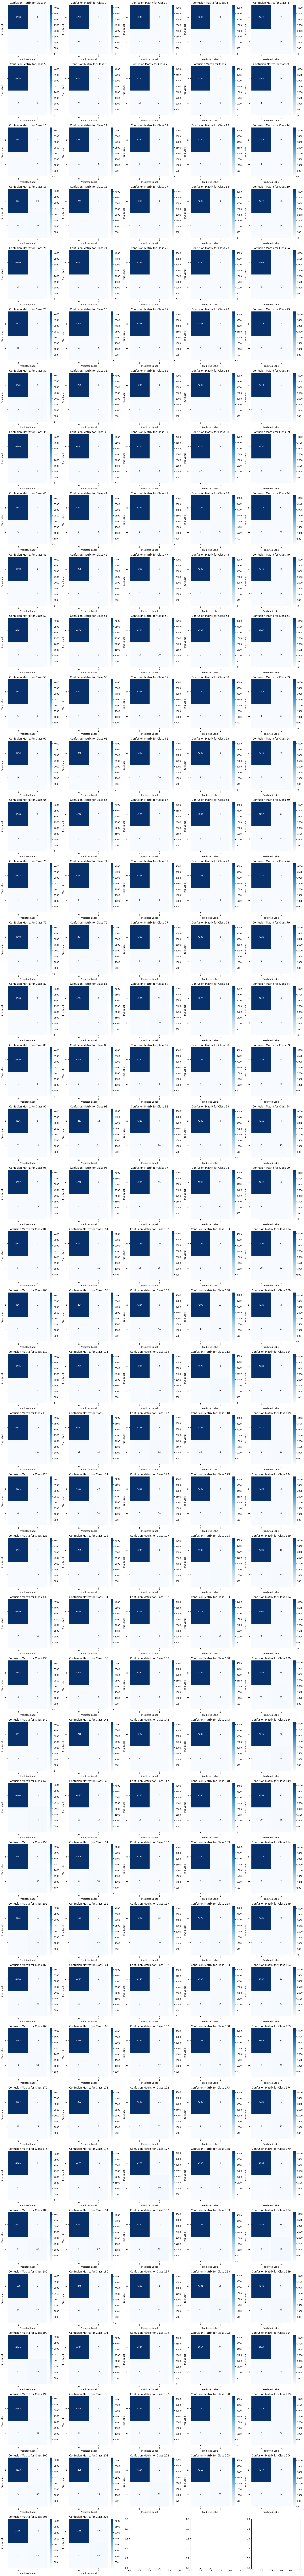

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Assuming y_true and y_pred are your true labels and predicted labels respectively
# y_true and y_pred should be in the shape (n_samples, n_classes)

# Compute multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix for each label
n_classes = mcm.shape[0]
max_plots_per_row = 5  # Maximum number of confusion matrices to plot per row
num_rows = int(np.ceil(n_classes / max_plots_per_row))

fig, axes = plt.subplots(num_rows, max_plots_per_row, figsize=(20, 4*num_rows))

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        idx = i * max_plots_per_row + j
        if idx < n_classes:
            sns.heatmap(mcm[idx], annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Confusion Matrix for Class {idx}')
            ax.set_xlabel('Predicted Label')
            ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()




In [11]:
#MLP Classifier
from sklearn.neural_network import MLPClassifier

# Define class weights
# Assuming 'class_weight' is a dictionary where keys are class labels and values are corresponding weights
class_weight = {-1: 1, 1: 5}

# Train a new DNN Classifier with selected features
dnn_classifier = MLPClassifier(random_state=42, max_iter=500)
dnn_classifier.fit(X_train_scaled, y_train)



/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=500, random_state=42)

In [12]:
# Make predictions on the test set
y_pred_mlp = dnn_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_mlp)
#f1 = f1_score(y_test, y_pred_mlp)
#recall = recall_score(y_test, y_pred_mlp)

print("\nMLP Classifier Model:")
print("Accuracy:", accuracy)
#print("F1 Score:", f1)
#print("Recall Score:", recall)

# Generate and print the classification report
report = classification_report(y_test, y_pred_mlp)
print("Classification Report:")
print(report)


MLP Classifier Model:
Accuracy: 0.6375617792421746
Classification Report:
              precision    recall  f1-score   support

        1034       0.00      0.00      0.00         1
        1036       0.77      0.77      0.77        13
        1044       0.00      0.00      0.00         1
        1053       0.00      0.00      0.00         3
        1055       0.00      0.00      0.00         0
        1060       0.00      0.00      0.00         0
        1063       0.00      0.00      0.00         0
        1066       0.75      1.00      0.86         3
        1069       0.73      0.41      0.52        27
        1076       0.00      0.00      0.00         0
        1089       0.00      0.00      0.00         1
        1108       0.00      0.00      0.00         0
        1116       0.25      0.50      0.33         2
        1128       0.50      0.18      0.27        11
        1133       0.58      0.78      0.67         9
        1137       0.00      0.00      0.00         2
      

/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

In [27]:
from sklearn.neighbors import KNeighborsClassifier

# Creating an instance of KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # Example: setting number of neighbors to 5

# Training the classifier
knn_classifier.fit(X_train_scaled, y_train)  # Assuming X_train and y_train are your training data

# Making predictions
y_pred_knn = knn_classifier.predict(X_test_scaled)  # Assuming X_test is your test data
accuracy = accuracy_score(y_test, y_pred_knn)

print("\nKNN Model:")
print("Accuracy:", accuracy)

# Generate and print the classification report
report = classification_report(y_test, y_pred_knn)
print("Classification Report:")
print(report)


KNN Model:
Accuracy: 0.27912449988232524
Classification Report:
              precision    recall  f1-score   support

        1034       0.00      0.00      0.00         1
        1036       0.35      0.62      0.44        13
        1037       0.00      0.00      0.00         0
        1044       0.00      0.00      0.00         1
        1053       0.00      0.00      0.00         3
        1055       0.00      0.00      0.00         0
        1060       0.00      0.00      0.00         0
        1063       0.00      0.00      0.00         0
        1066       0.06      0.67      0.11         3
        1069       0.17      0.30      0.22        27
        1076       0.00      0.00      0.00         0
        1089       0.00      0.00      0.00         1
        1108       0.00      0.00      0.00         0
        1116       0.00      0.00      0.00         2
        1128       0.16      0.27      0.20        11
        1133       0.08      0.11      0.10         9
        1137    

/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

In [30]:
from sklearn.tree import DecisionTreeClassifier

# Creating an instance of DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier(random_state=42)  # Example: setting random_state for reproducibility

# Training the classifier
decision_tree_classifier.fit(X_train_scaled, y_train)  # Assuming X_train_scaled and y_train are your scaled training data

# Making predictions
y_pred_decision_tree = decision_tree_classifier.predict(X_test_scaled)  # Assuming X_test_scaled is your scaled test data
accuracy = accuracy_score(y_test, y_pred_decision_tree)

print("\nDecision Tree Classifier Model:")
print("Accuracy:", accuracy)

# Generate and print the classification report
report = classification_report(y_test, y_pred_decision_tree)
print("Classification Report:")
print(report)


Decision Tree Classifier Model:
Accuracy: 0.7387620616615674
Classification Report:
              precision    recall  f1-score   support

        1034       0.00      0.00      0.00         1
        1036       0.85      0.85      0.85        13
        1044       0.33      1.00      0.50         1
        1053       1.00      0.33      0.50         3
        1055       0.00      0.00      0.00         0
        1066       0.50      0.33      0.40         3
        1069       0.71      0.56      0.62        27
        1089       0.00      0.00      0.00         1
        1108       0.00      0.00      0.00         0
        1116       0.67      1.00      0.80         2
        1128       0.83      0.45      0.59        11
        1133       0.90      1.00      0.95         9
        1137       0.33      0.50      0.40         2
        1162       0.00      0.00      0.00         0
        1163       0.50      1.00      0.67         1
        1166       0.71      0.64      0.67       

/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

In [31]:
# Load the real dataset
real_data = pd.read_csv('test.csv')
real_data

,game,season,home_team,away_team,starting_min,end_min,home_0,home_1,home_2,home_3,...,pf_visitor,reb_visitor,dreb_visitor,oreb_visitor,to_visitor,pts_visitor,pct_visitor,pct_2_visitor,pct_3_visitor,outcome
0,200612290WAS,2007,WAS,ORL,39,41,Antawn Jamison,Antonio Daniels,Calvin Booth,Gilbert Arenas,...,1,1,1,0,0,4,1.000000,1.000000,0,1
1,200612300MIL,2007,MIL,WAS,5,6,Andrew Bogut,Brian Skinner,Charlie Bell,Michael Redd,...,1,2,2,0,0,2,0.200000,0.333333,0,1
2,200612300MIL,2007,MIL,WAS,15,17,Andrew Bogut,Michael Redd,Mo Williams,Ruben Patterson,...,1,5,4,1,1,4,0.333333,0.666667,0,1
3,200612300MIL,2007,MIL,WAS,18,21,Andrew Bogut,Michael Redd,Mo Williams,Ruben Patterson,...,0,5,5,0,3,4,0.400000,0.500000,0,1
4,200612300MIL,2007,MIL,WAS,25,28,Andrew Bogut,Brian Skinner,Charlie Bell,Michael Redd,...,1,2,1,1,1,8,0.400000,0.400000,0,1
5,200612300MIL,2007,MIL,WAS,36,36,Andrew Bogut,Charlie Bell,Michael Redd,Ruben Patterson,...,0,0,0,0,0,0,0.000000,0.000000,0,1
6,200612300MIL,2007,MIL,WAS,37,39,Brian Skinner,Charlie Bell,Michael Redd,Ruben Patterson,...,0,3,2,1,2,2,0.200000,0.200000,0,1
7,200612300MIL,2007,MIL,WAS,40,41,Brian Skinner,Charlie Bell,Michael Redd,Ruben Patterson,...,0,2,0,2,0,2,0.333333,0.333333,0,1
8,200612300MIL,2007,MIL,WAS,42,42,Brian Skinner,Charlie Bell,Michael Redd,Mo Williams,...,0,0,0,0,0,0,0.000000,0.000000,0,1
9,200612300MIL,2007,MIL,WAS,43,44,Brian Skinner,Charlie Bell,Michael Redd,Mo Williams,...,0,2,0,2,0,6,0.500000,0.500000,0,1


In [32]:

# Select only the features selected during training
real_data_selected = real_data[selected_features[:-1]]  # Exclude the target variable 'outcome'
# Use the same mapping for new data
for col in player_name_columns:
    if col in real_data_selected.columns:
        real_data_selected.loc[:, col] = player_encoder.transform(real_data_selected[col]).astype(int)

real_data_selected

,home_team,away_team,home_0,home_1,home_2,home_3,away_0,away_1,away_2,away_3,away_4,outcome
0,1027,1012,1238,1507,1507,1086,1507,1266,1367,1317,1454,1
1,1009,1027,1184,1504,1507,1286,1238,1507,1212,1186,1086,1
2,1009,1027,1184,1286,1243,1507,1239,1507,1507,1212,1507,1
3,1009,1027,1184,1286,1243,1507,1239,1238,1186,1086,1507,1
4,1009,1027,1184,1504,1507,1286,1238,1507,1212,1186,1086,1
5,1009,1027,1184,1507,1286,1507,1507,1507,1212,1086,1507,1
6,1009,1027,1504,1507,1286,1507,1507,1507,1212,1086,1507,1
7,1009,1027,1504,1507,1286,1507,1238,1507,1212,1186,1086,1
8,1009,1027,1504,1507,1286,1243,1238,1507,1212,1186,1086,1
9,1009,1027,1504,1507,1286,1243,1238,1212,1186,1086,1507,1


In [33]:
# Scale the features using the same scaler
X_real_scaled = scaler.transform(real_data_selected)

# Make predictions on the real data using the trained random forest classifier
y_pred_real = rf_model.predict(X_real_scaled)

# Print the predictions
print("Predictions on real data encoded:", y_pred_real)

# Print the decoded predictions in one line with commas and spaces between names
print("Predictions on real data decoded:", ", ".join(player_encoder.decode_label(prediction) for prediction in y_pred_real))

Predictions on real data encoded: [1474 1452 1496 1489 1452 1489 1489 1489 1452 1452 1452]
Predictions on real data decoded: Wesley Johnson, Ryan Anderson, Troy Murphy, Tyrus Thomas, Ryan Anderson, Tyrus Thomas, Tyrus Thomas, Tyrus Thomas, Ryan Anderson, Ryan Anderson, Ryan Anderson


In [ ]:
Jarvis Hayes
Mo Williams
Steve Blake
Steve Blake
Mo Williams
Steve Blake
Steve Blake
Steve Blake
Ruben Patterson
Ruben Patterson
Ruben Patterson

In [34]:
# Scale the features using the same scaler
X_real_scaled = scaler.transform(real_data_selected)

# Make predictions on the real data using the trained MLP classifier
y_pred_real = dnn_classifier.predict(X_real_scaled)

# Print the predictions
print("Predictions on real data:", y_pred_real)

# Print the decoded predictions in one line with commas and spaces between names
print("Predictions on real data:", ", ".join(player_encoder.decode_label(prediction) for prediction in y_pred_real))


Predictions on real data: [1393 1482 1496 1496 1482 1499 1492 1492 1492 1492 1492]
Predictions on real data: Terrence Williams, Ryan Reid, Troy Murphy, Troy Murphy, Ryan Reid, Zach Randolph, Malcolm Thomas, Malcolm Thomas, Malcolm Thomas, Malcolm Thomas, Malcolm Thomas


In [18]:

print("Shape of X_train_scaled:", X_train_scaled.shape[1])

Shape of X_train_scaled: 12


In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras import callbacks


# Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,  # minimum amount of change to count as an improvement
    patience=20,      # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# Layers
model.add(Dense(units=128, kernel_initializer='uniform', input_dim=12))
model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU activation
model.add(Dropout(0.5))
model.add(Dense(units=64, kernel_initializer='uniform'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units=32, kernel_initializer='uniform'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00001)  # Decrease learning rate
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the ANN
history = model.fit(X_train_scaled, y_train, batch_size=128, epochs=150, callbacks=[early_stopping], validation_split=0.2)


Epoch 1/150


/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: -0.1541 - val_accuracy: 0.0000e+00 - val_loss: -2.9324
Epoch 2/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.0000e+00 - loss: -4.1218 - val_accuracy: 0.0000e+00 - val_loss: -7.4479
Epoch 3/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.0000e+00 - loss: -9.0499 - val_accuracy: 0.0000e+00 - val_loss: -13.3349
Epoch 4/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.0000e+00 - loss: -15.6280 - val_accuracy: 0.0000e+00 - val_loss: -21.4886
Epoch 5/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.0000e+00 - loss: -24.6565 - val_accuracy: 0.0000e+00 - val_loss: -33.3268
Epoch 6/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: -37.6641 - val_accuracy: 0.0000e+00 - val_loss: -50.4328
Epoch 7/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.0000e+00 - loss: -56.5463 - val_accuracy: 0.0000e+00 - val_loss: -74.4775
Epoch 8/150
107/107 